# Ein zwei-schichtiges Neurales Netzwerk: Schritt für Schritt #

In dieesm Notebook werden Sie ein tiefes neuronales Netzwerk mit zwei Schichten für die Klassifizierung von Bildern implementieren.

Das Modell soll die folgende Struktur haben:<br>
*LINEAR -> RELU -> LINEAR -> SIGMOID*.

## 1 - Imports

In [ ]:
import numpy as np
import h5py
import scipy
import matplotlib.pyplot as plt
from PIL import Image
from scipy import ndimage

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 2 - Hilfsfunktionen##
Aktivierungsfunktionen (Forwärts and Rückwärts).

In [ ]:
def sigmoid(Z):
    """
    Implements the sigmoid activation in numpy 
    Arguments:
      Z -- numpy array of any shape
    Returns:
      A -- output of sigmoid(z), same shape as Z
    """
    A = 1/(1+np.exp(-Z))
    
    return A

def relu(Z):
    """
    Implement the RELU function.
    Arguments:
      Z -- Output of the linear layer, of any shape
    Returns:
      A -- Post-activation parameter, of the same shape as Z
    """
    A = np.maximum(0,Z)
    assert(A.shape == Z.shape)

    return A


def relu_backward(dA, Z):
    """
    Implement the backward propagation for a single RELU unit.
    Arguments:
      dA -- post-activation gradient, of any shape
      Z -- input of the relu(Z) during the forward propagation (computed and stored to be used in backprop)
    Returns:
      dZ -- Partial derivative of the cost with respect to Z
    """
    dZ = np.array(dA, copy=True)  # just converting dz to a correct object.
    dZ[Z <= 0] = 0                # When z <= 0, you should set dz to 0 as well. 
    assert (dZ.shape == Z.shape)
    
    return dZ

def sigmoid_backward(dA, Z):
    """
    Implement the backward propagation for a single SIGMOID unit.
    Arguments:
      dA -- post-activation gradient, of any shape
      Z -- input of the relu(Z) during the forward propagation (computed and stored to be used in backprop)
    Returns:
      dZ -- Partial derivative of the cost with respect to Z
    """
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    assert (dZ.shape == Z.shape)
    
    return dZ

## 3 - Das Laden und Aufbereıten der Daten  ##

Ihr Datensatz (train_catvnoncat.h5 und test_catvnoncat.h5) enthält:
- m_train Trainingsbilder, 
- m_test Testbiler,

die alle mit "Katze" (y=1) oder "nicht-Katze" (y=0) markiert sind.

Jedes Bild hat das Format (num_px, num_px, 3), wobei 3 für die 3 Farbkanäle (RGB) steht. Somit sind die Bilder quadratisch mit (height = num_px) und (width = num_px).

Stellen Sie sicher, dass die Daten im selben Ordner wie das Notebook liegen, oder passen Sie den Pfad entsprechend an. 

In [ ]:
# Loading the data (cat/non-cat)
#train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()
train_dataset = h5py.File('train_catvnoncat.h5', "r")
train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

test_dataset = h5py.File('test_catvnoncat.h5', "r")
test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

classes = np.array(test_dataset["list_classes"][:]) # the list of classes

### Q : What does the h5py file, i.e. the "train_dataset" variable, contain exactly? How can we find out?

In [ ]:
# Check the shape of train_set_y_orig and test_set_y_orig (labels)
print ("train_set_y_orig shape: " + str(train_set_y_orig.shape))
print ("test_set_y_orig shape: " + str(test_set_y_orig.shape))
print("test_set_y_orig: " + str(test_set_y_orig))

### Q : Is this data set balanced? Are there an equal number of images in both classes?
### Q : What problems could arise with an unbalanced dataset?

train_set_y_orig shape: (209,)
test_set_y_orig shape: (50,)
test_set_y_orig: [1 1 1 1 1 0 1 1 1 1 1 1 1 0 0 1 0 1 1 1 1 0 0 1 1 1 1 0 1 0 1 1 1 1 0 0 0
 1 0 0 1 1 1 0 0 0 1 1 1 0]


In [ ]:
# Reshape train_set_y_orig, such that it has the shape (1, m_train)
# Reshape test_set_y_orig, such that it has the shape (1, m_test)

### START HERE: Replace the "None" instances with your code ###
train_set_y = train_set_y_orig.reshape(1,len(train_set_y_orig))
test_set_y = test_set_y_orig.reshape(1,len(test_set_y_orig))
### END HERE ###

In [ ]:
# Check the sizes
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_y shape: " + str(test_set_y.shape))
print("test_set_y: " + str(test_set_y))

### Q : What is the difference between the shapes (50,) and (1,50) ?

train_set_y shape: (1, 209)
test_set_y shape: (1, 50)
test_set_y: [[1 1 1 1 1 0 1 1 1 1 1 1 1 0 0 1 0 1 1 1 1 0 0 1 1 1 1 0 1 0 1 1 1 1 0 0
  0 1 0 0 1 1 1 0 0 0 1 1 1 0]]


y = [1], it's a 'cat' picture.


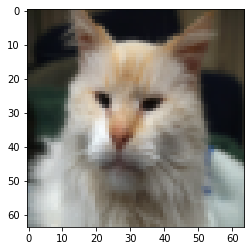

In [ ]:
# Example of the picture at the given index
index = 27
plt.imshow(train_set_x_orig[index])
print ("y = " + str(train_set_y[:, index]) + ", it's a '" + classes[np.squeeze(train_set_y[:, index])].decode("utf-8") +  "' picture.")

In [ ]:
# Explore your dataset 
m_train = train_set_x_orig.shape[0]
num_px = train_set_x_orig.shape[1]
m_test = test_set_x_orig.shape[0]

print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))
print ("Height/Width of each image: num_px = " + str(num_px))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_set_x shape: " + str(train_set_x_orig.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x shape: " + str(test_set_x_orig.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

Number of training examples: m_train = 209
Number of testing examples: m_test = 50
Height/Width of each image: num_px = 64
Each image is of size: (64, 64, 3)
train_set_x shape: (209, 64, 64, 3)
train_set_y shape: (1, 209)
test_set_x shape: (50, 64, 64, 3)
test_set_y shape: (1, 50)


In [ ]:
# Reshape the training and test examples
train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T   # The "-1" makes reshape flatten the remaining dimensions
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T

In [ ]:
# Check the shapes. 12288 equals 64x64x3, which is the size of one reshaped image vector.
print ("train_set_x_flatten shape: " + str(train_set_x_flatten.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x_flatten shape: " + str(test_set_x_flatten.shape))
print ("test_set_y shape: " + str(test_set_y.shape))
print ("sanity check after reshaping: " + str(train_set_x_flatten[0:5,0]))

train_set_x_flatten shape: (12288, 209)
train_set_y shape: (1, 209)
test_set_x_flatten shape: (12288, 50)
test_set_y shape: (1, 50)
sanity check after reshaping: [17 31 56 22 33]


In [ ]:
# Standardize data to have feature values between 0 and 1.
train_set_x = train_x_flatten/255.
test_set_x = test_x_flatten/255.

### Q : Why is standardizing important? What is the purpose?

## 4 - Initialisierung der Parameter

Implementieren Sie die Funktion `initialize_parameters`, das die Parameter des zwei-schichtigen Netzwerkes initialisieren wird. Die Anzahl der Zellen in den einzelnen Schichten werden dieser Funktion als Eingabe übergeben; diese Zahlen bestimmen eindeutig die Dimensionen der Parameter-Matrizen.

- Verwenden Sie zufällige Initialisierung für die Gewichte: `np.random.randn(shape)*0.01` mit dem richtigen "shape".
- Verwenden Sie Null-Initialisierung für die Bias-Terme : `np.zeros(shape)`.


In [ ]:
def initialize_parameters(n_x, n_h, n_y):
    """
    Argument:
    n_x -- size of the input layer
    n_h -- size of the hidden layer
    n_y -- size of the output layer
    
    Returns:
    parameters -- python dictionary containing your parameters:
                    W1 -- weight matrix of shape (n_h, n_x)
                    b1 -- bias vector of shape (n_h, 1)
                    W2 -- weight matrix of shape (n_y, n_h)
                    b2 -- bias vector of shape (n_y, 1)
    """
    
    np.random.seed(1)
    
    ### START HERE: Replace the "None" instances with your code ###
    W1 = np.random.randn(n_h,n_x)*0.01
    b1 = np.zeros((n_h,1))
    W2 = np.random.randn(n_y,n_h)*0.01
    b2 = np.zeros((n_y,1))
    ### END CODE HERE ###
    
    assert(W1.shape == (n_h, n_x))
    assert(b1.shape == (n_h, 1))
    assert(W2.shape == (n_y, n_h))
    assert(b2.shape == (n_y, 1))
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters   

### Q : How can you modify this function, so that it can be used for DNNs with more than one hidden layer?
### Q : Why is it not a good idea to use zero initialization for the weight matrices? (Hint: symmetry braking) 

### Test your code

In [ ]:
parameters = initialize_parameters(3,2,1)
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

W1 = [[ 0.01624345 -0.00611756 -0.00528172]
 [-0.01072969  0.00865408 -0.02301539]]
b1 = [[0.]
 [0.]]
W2 = [[ 0.01744812 -0.00761207]]
b2 = [[0.]]


**Expected output**:
       
<table style="width:80%">
  <tr>
    <td> **W1** </td>
    <td> [[ 0.01624345 -0.00611756 -0.00528172]
 [-0.01072969  0.00865408 -0.02301539]] </td> 
  </tr>

  <tr>
    <td> **b1**</td>
    <td>[[ 0.]
 [ 0.]]</td> 
  </tr>
  
  <tr>
    <td>**W2**</td>
    <td> [[ 0.01744812 -0.00761207]]</td>
  </tr>
  
  <tr>
    <td> **b2** </td>
    <td> [[ 0.]] </td> 
  </tr>
  
</table>

## 5 - Forward propagation ##
Implementäeren Sie eine Schicht der Forwärtspropagation, i.e. eine Linearkonbination gefolgt von einer Activierung: "[LINEAR->ACTIVATION]".

**Bemerkung**: In Deep Learning wird die "[LINEAR->ACTIVATION]" Berechnung als eine Schicht im Netzwerk betrachtet. 

Die mathematische Formulierung dieses Schrittes ist

$$Z^{[l]} = W^{[l]}A^{[l-1]} +b^{[l]}$$

$$A^{[l]} = g(Z^{[l]})$$

wobei "g()" die Aktivierungsfunktion ist und zum Beispiel sigmoid() oder relu() sein kann. Wir stellen die Implementierungen dieser Aktivierungsfunktionen für Sie bereit (siehe: Hilfsfunktionen).

Die Funktion `np.dot()` könnte auch hilfreich sein. Wenn die Dimensionen nicht stimmen sollten, könnte das Ausgeben von `W.shape` helfen.

In [ ]:
def forward_step(A_prev, W, b, activation):
    """
    Implement the forward propagation step for the LINEAR->ACTIVATION layer

    Arguments:
    A_prev -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"

    Returns:
    A -- the output of the activation function, also called the post-activation value 
    cache -- a python tuple containing A_prev, W, b, Z;
             stored for computing the backward pass efficiently
    """
    
    ### START HERE: Replace the "None" instances with your code ###
    
    # The linear part of a layer's forward propagation.
    Z = np.dot(W,A_prev)+b

    assert(Z.shape == (W.shape[0], A_prev.shape[1]))
    linear_cache = (A_prev, W, b)

    # The none-linear part
    if activation == "sigmoid":
        A = sigmoid(Z)
    
    elif activation == "relu":   
        A = relu(Z)
        
    ### END CODE HERE ###
    
    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (A_prev, W, b, Z)

    return A, cache

### Test your code ###

In [ ]:
np.random.seed(2)
A_prev = np.random.randn(3,2)
W = np.random.randn(1,3)
b = np.random.randn(1,1)

A, cache = forward_step(A_prev, W, b, activation = "sigmoid")
print("With sigmoid: A = " + str(A))

A, cache = forward_step(A_prev, W, b, activation = "relu")
print("With ReLU: A = " + str(A))

With sigmoid: A = [[0.96890023 0.11013289]]
With ReLU: A = [[3.43896131 0.        ]]


**Expected output**:
       
<table style="width:35%">
  <tr>
    <td> **With sigmoid: A ** </td>
    <td > [[ 0.96890023  0.11013289]]</td> 
  </tr>
  <tr>
    <td> **With ReLU: A ** </td>
    <td > [[ 3.43896131  0.        ]]</td> 
  </tr>
</table>


## 6 - Kostenfunktion

Berechnen Sie die Cross-Entropy Kosten $J$ mit Hilfe der folgenden Formel: $$-\frac{1}{m} \sum\limits_{i = 1}^{m} (y^{(i)}\log\left(a^{[L] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[L](i)}\right)) \tag{1}$$

Sie müssen die Kosten berechnen und verfolgen um sicherzustellen, dass die Kosten sinken und das Modell tatsächlich "lernt".


In [ ]:
def compute_cost(AL, Y):
    """
    Implement the cost function defined by equation (7).

    Arguments:
    AL -- probability vector corresponding to your label predictions, shape (1, number of examples)
    Y -- true "label" vector (for example: containing 0 if non-cat, 1 if cat), shape (1, number of examples)

    Returns:
    cost -- cross-entropy cost
    """
    
    m = Y.shape[1]  # number of examples

    ### START HERE: Replace the "None" instances with your code ###
    
    # Compute loss from aL and y.
    cost = -1/m*np.sum(((Y*np.log(AL))+((1-Y)*np.log(1-AL))))
    print(cost)
    ### END CODE HERE ###
    
    cost = np.squeeze(cost)      # To make sure your cost's shape is what we expect (e.g. this turns [[17]] into 17).
    assert(cost.shape == ())
    
    return cost

### Test your code

In [ ]:
Y = np.asarray([[1, 1, 1]])
AL = np.array([[.8,.9,0.4]])

print("cost = " + str(compute_cost(AL, Y)))

0.41493159961539694
cost = 0.41493159961539694


**Expected Output**:

<table>
    <tr>
    <td>**cost** </td>
    <td> 0.41493159961539694</td> 
    </tr>
</table>

## 7 - Backward propagation

Implementieren Sie einen Rückwerts-Schritt für einen *LINEAR->ACTIVATION* Forwärts-Schritt.

Die zwei Rückwärts-Funktionen **`sigmoid_backward`** und **`relu_backward`** sollen Ihnen bei der Implementierung von `backward_step` helfen.

Die Funktion `backward_step` bekommt als Eingabe folgendes übergeben:
- $dA^{[l]}$: der bisherige Teil der "Kette" (in der Kettenregel) ausgewertet,
- $A^{[l-1]}, W^{[l]}, b^{[l]}, Z^{[l]}$: die im "cache" gespeicherten Werte, die im Forwärtsschritt berechnet wurden, 
- die AKtivierung der aktuellen Schicht.

Die Funktion berechnet folgende partiellen Ableitungen, die den aktuellen Teil der "Kette" bilden. $g(.)$ ist die Aktivaierungsfunktion der aktuellen Schicht, entsprechend ist $g'$ entweder `sigmoid_backward` oder `relu_backward`.

$$dZ^{[l]} := \frac{\partial \mathcal{J} }{\partial Z^{[l]}} = dA^{[l]} * g'(Z^{[l]}) \tag{2}$$<br>

$$ dW^{[l]} := \frac{\partial \mathcal{J} }{\partial W^{[l]}} = \frac{1}{m} dZ^{[l]} A^{[l-1] T} \tag{3}$$<br>

$$ db^{[l]} := \frac{\partial \mathcal{J} }{\partial b^{[l]}} = \frac{1}{m} \sum_{i = 1}^{m} dZ^{[l](i)}\tag{4}$$<br>

$$ dA^{[l-1]} := \frac{\partial \mathcal{L} }{\partial A^{[l-1]}} = W^{[l] T} dZ^{[l]} \tag{5}$$<br>

Die Funktion soll folgendes zurückgeben:
- $dA^{[l-1]}$, für den nächsten Rückwärtschritt, 
- $dW^{[l]} \quad$ und $\quad db^{[l]} \quad$ für die Parameter-Aktualisirungen.


<!-- 
For those of you who are expert in calculus (you don't need to be to do this assignment), the chain rule of calculus can be used to derive the derivative of the loss $\mathcal{L}$ with respect to $z^{[1]}$ in a 2-layer network as follows:

$$\frac{d \mathcal{L}(a^{[2]},y)}{{dz^{[1]}}} = \frac{d\mathcal{L}(a^{[2]},y)}{{da^{[2]}}}\frac{{da^{[2]}}}{{dz^{[2]}}}\frac{{dz^{[2]}}}{{da^{[1]}}}\frac{{da^{[1]}}}{{dz^{[1]}}} \tag{8} $$

In order to calculate the gradient $dW^{[1]} = \frac{\partial L}{\partial W^{[1]}}$, you use the previous chain rule and you do $dW^{[1]} = dz^{[1]} \times \frac{\partial z^{[1]} }{\partial W^{[1]}}$. During the backpropagation, at each step you multiply your current gradient by the gradient corresponding to the specific layer to get the gradient you wanted.

Equivalently, in order to calculate the gradient $db^{[1]} = \frac{\partial L}{\partial b^{[1]}}$, you use the previous chain rule and you do $db^{[1]} = dz^{[1]} \times \frac{\partial z^{[1]} }{\partial b^{[1]}}$.

This is why we talk about **backpropagation**.
!-->

In [ ]:
def backward_step(dA, cache, activation):
    """
    Implement the backward propagation for the LINEAR->ACTIVATION layer.
    
    Arguments:
    dA -- post-activation gradient for current layer l 
    cache -- tuple of values (A_prev, W, b, Z) we stored for computing backward propagation efficiently
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"
    
    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    A_prev, W, b, Z = cache
    m = A_prev.shape[1]

    ### START HERE: Replace the "None" instances with your code ###

    # The non-linear backward part
    if activation == "relu":
        dZ = relu_backward(dA,Z)
        
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA,Z)
    

    # The linear backward part
    dW = (1/m)*np.dot(dZ,A_prev.T)
    db = (1/m)*np.sum(dZ,axis=1,keepdims=True)
    dA_prev = np.dot(W.T,dZ)
    
    ### END CODE HERE ###
    
    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)
    
    return dA_prev, dW, db

### Q : Give a short explanation of what relu_backward is doing
### Q : What happens when the "axis" parameter of np.sum is set to 1?

### Test your code

In [ ]:
np.random.seed(2)
dAL = np.random.randn(1,2)
A = np.random.randn(3,2)
W = np.random.randn(1,3)
b = np.random.randn(1,1)
Z = np.random.randn(1,2)
cache = (A, W, b, Z)

dA_prev, dW, db = backward_step(dAL,cache, activation = "sigmoid")
print ("sigmoid:")
print ("dA_prev = "+ str(dA_prev))
print ("dW = " + str(dW))
print ("db = " + str(db) + "\n")

dA_prev, dW, db = backward_step(dAL, cache, activation = "relu")
print ("relu:")
print ("dA_prev = "+ str(dA_prev))
print ("dW = " + str(dW))
print ("db = " + str(db))

sigmoid:
dA_prev = [[ 0.11017994  0.01105339]
 [ 0.09466817  0.00949723]
 [-0.05743092 -0.00576154]]
dW = [[ 0.10266786  0.09778551 -0.01968084]]
db = [[-0.05729622]]

relu:
dA_prev = [[ 0.44090989  0.        ]
 [ 0.37883606  0.        ]
 [-0.2298228   0.        ]]
dW = [[ 0.44513824  0.37371418 -0.10478989]]
db = [[-0.20837892]]


**Expected output with sigmoid:**

<table style="width:100%">
  <tr>
    <td > dA_prev </td> 
           <td >[[ 0.11017994  0.01105339]
 [ 0.09466817  0.00949723]
 [-0.05743092 -0.00576154]] </td> 
  </tr> 
    <tr>
    <td > dW </td> 
           <td > [[ 0.10266786  0.09778551 -0.01968084]] </td> 
  </tr> 
    <tr>
    <td > db </td> 
           <td > [[-0.05729622]] </td> 
  </tr> 
</table>



**Expected output with relu:**

<table style="width:100%">
  <tr>
    <td > dA_prev </td> 
           <td > [[ 0.44090989  0.        ]
 [ 0.37883606  0.        ]
 [-0.2298228   0.        ]] </td> 
  </tr> 
    <tr>
    <td > dW </td> 
           <td > [[ 0.44513824  0.37371418 -0.10478989]] </td> 
  </tr> 
    <tr>
    <td > db </td> 
           <td > [[-0.20837892]] </td> 
  </tr> 
</table>



## 8 - Aktualisierung der Parameter
Implementieren Sie die Funktion `update_parameters()`, die mit Hilfe des Gradient Descent Algorithmus die Parameter aktualisiert:

$$ W^{[l]} = W^{[l]} - \alpha \text{ } dW^{[l]} \tag{16}$$
$$ b^{[l]} = b^{[l]} - \alpha \text{ } db^{[l]} \tag{17}$$

wobei $\alpha$ die Lernrate ist.

In [ ]:
def update_parameters(parameters, grads, learning_rate):
    """
    Update parameters using gradient descent
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    grads -- python dictionary containing your gradients, output of L_model_backward
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
                  parameters["W" + str(l)] = ... 
                  parameters["b" + str(l)] = ...
    """

    ### START HERE: Replace the "None" instances with your code ###
    parameters["W1"] = parameters["W1"]-learning_rate*grads['dW1']
    parameters["b1"] = parameters["b1"]-learning_rate*grads['db1']
    parameters["W2"] = parameters["W2"]-learning_rate*grads['dW2']
    parameters["b2"] = parameters["b2"]-learning_rate*grads['db2']
    ### END CODE HERE ###
    return parameters

### Test your code

In [ ]:
np.random.seed(2)
W1 = np.random.randn(3,4)
b1 = np.random.randn(3,1)
W2 = np.random.randn(1,3)
b2 = np.random.randn(1,1)
parameters = {"W1": W1, "b1": b1, "W2": W2, "b2": b2}
np.random.seed(3)
dW1 = np.random.randn(3,4)
db1 = np.random.randn(3,1)
dW2 = np.random.randn(1,3)
db2 = np.random.randn(1,1)
grads = {"dW1": dW1, "db1": db1, "dW2": dW2, "db2": db2}
parameters = update_parameters(parameters, grads, 0.1)

print ("W1 = "+ str(parameters["W1"]))
print ("b1 = "+ str(parameters["b1"]))
print ("W2 = "+ str(parameters["W2"]))
print ("b2 = "+ str(parameters["b2"]))

W1 = [[-0.59562069 -0.09991781 -2.14584584  1.82662008]
 [-1.76569676 -0.80627147  0.51115557 -1.18258802]
 [-1.0535704  -0.86128581  0.68284052  2.20374577]]
b1 = [[-0.04659241]
 [-1.28888275]
 [ 0.53405496]]
W2 = [[-0.55569196  0.0354055   1.32964895]]
b2 = [[-0.84610769]]


**Expected Output**:

<table style="width:100%"> 
    <tr>
    <td > W1 </td> 
           <td > [[-0.59562069 -0.09991781 -2.14584584  1.82662008]
 [-1.76569676 -0.80627147  0.51115557 -1.18258802]
 [-1.0535704  -0.86128581  0.68284052  2.20374577]] </td> 
  </tr>
    <tr>
    <td > b1 </td> 
           <td > [[-0.04659241]
 [-1.28888275]
 [ 0.53405496]] </td> 
  </tr> 
  <tr>
    <td > W2 </td> 
           <td > [[-0.55569196  0.0354055   1.32964895]]</td> 
  </tr> 
    <tr>
    <td > b2 </td> 
           <td > [[-0.84610769]] </td> 
  </tr> 
</table>


### 9 - Das Model ###

Implementieren Sie die Funktion `train_model`, das als Eingabe folgende Daten übernimmt
- die Trianingsdaten,
- die Netzwerkstruktur (Dimensionen und Aktivierungen der einzelnen Schichten)
- die Lernrate ($0.0075$ default Wert),
- die Anzahl der Iterationen (3000 default Wert),
- einen Boolean Wert, der angibt, ob die Kosten ausgegeben werden sollen.

Die Funktion soll die gelernten Parameter zurückgeben.

In [ ]:
def train_model(X, Y, layer_dims, activations, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):
    """
    Implements a two-layer neural network.
    
    Arguments:
    X -- input data, of shape (n_x, number of examples)
    Y -- true "label" vector (containing 1 if cat, 0 if non-cat), of shape (1, number of examples)
    layers_dims -- dimensions of the layers (n_x, n_h, n_y)
    activations -- activations of the layers ("relu", "sigmoid")
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- If set to True, this will print the cost every 100 iterations 
    
    Returns:
    parameters -- a dictionary containing W1, W2, b1, and b2
    """
    
    np.random.seed(1)
    grads = {}
    costs = []                                # to keep track of the cost
    m = X.shape[1]                            # number of examples

    # layer_dims = (number of features, dimension of the hidden layer, number of output neurons)
    n_x, n_h, n_y = layer_dims   
    # activations = (activation of layer 1, activation of layer 2)          
    g1, g2 = activations

    assert (n_x == X.shape[0])
    assert (n_y == Y.shape[0])
    
    ### START HERE: Replace the "None" instances with your code ###
    # Initialize parameters dictionary, by calling one of the functions you'd previously implemented
    parameters = initialize_parameters(n_x,n_h,n_y)
    ### END CODE HERE ###
    
    # Get W1, b1, W2 and b2 from the dictionary parameters.
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    # Loop (gradient descent)

    for i in range(0, num_iterations):

        ### START HERE: Replace the "None" instances with your code ###
        # Forward propagation: LINEAR -> RELU -> LINEAR -> SIGMOID. Inputs: "X, W1, b1, W2, b2". Output: "A1, cache1, A2, cache2".
        A1, cache1 = forward_step(X,W1,b1,g1)
        A2, cache2 = forward_step(A1,W2,b2,g2)
        ### END CODE HERE ###
        
        # Compute cost
        cost = compute_cost(A2,Y)
        ### END CODE HERE ###
        
        # Initializing backward propagation
        dA2 = - (np.divide(Y, A2) - np.divide(1 - Y, 1 - A2))
        
        # Backward propagation. Inputs: "dA2, cache2, cache1". Outputs: "dA1, dW2, db2; also dA0 (not used), dW1, db1".
        dA1, dW2, db2 = backward_step(dA2,cache2,g2)
        dA0, dW1, db1 = backward_step(dA1,cache1,g1)
        
        # Set grads['dWl'] to dW1, grads['db1'] to db1, grads['dW2'] to dW2, grads['db2'] to db2
        grads['dW1'] = dW1
        grads['db1'] = db1
        grads['dW2'] = dW2
        grads['db2'] = db2
        
        # Update parameters.
        parameters = update_parameters(parameters,grads,learning_rate)
        
        ### END CODE HERE ###

        # Retrieve W1, b1, W2, b2 from parameters
        W1 = parameters["W1"]
        b1 = parameters["b1"]
        W2 = parameters["W2"]
        b2 = parameters["b2"]
        
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if print_cost and i % 100 == 0:
            costs.append(cost)
       
    # plot the cost

    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

    ### Q : What does np.divide do exactly?

### 10 - Das Training

Trainieren Sie die Parameter und beobachten Sie, ob Ihr Modell tatsächlich lernt. Die Kosten sollen fallen. 

Die 2500 Iterationen können ca. 5 Minuten in Anspruch nehmen. Hätten Sie nicht die vektorisierte Implementierung genutzt, hätte es 10 mal so lange dauern können.

Nach dem Training erhalten Sie die gelernten **Parameter** des zwei-schichtigen Neuronalen Netzes. Diese Parameter entsprechen Ihrer Hypothesenfunktion $h_{\theta}(x)$.

In [ ]:
# The following parameters determine the architecture of the network
n_x = 12288     # 64 x 64 x 3
n_h = 7
n_y = 1
layer_dims = (n_x, n_h, n_y)
activations = ("relu", "sigmoid")

0.693049735659989
Cost after iteration 0: 0.693049735659989
0.6926114346158594
0.6921772249299877
0.6917552969254053
0.6913435039192125
0.6909413076936088
0.6905374978216907
0.6901226460083468
0.6896996461490383
0.6892649194044295
0.6888180223157058
0.6883544863326722
0.6878723543793064
0.6873715141970556
0.6868477883672164
0.6862993037700852
0.6857278097649128
0.6851299105519605
0.6845041875313205
0.6838513822703769
0.6831687021908813
0.6824544844489574
0.6817078582534385
0.6809295301997609
0.6801181839504155
0.6792738837540342
0.678396438926087
0.6774845829341244
0.6765396642037915
0.6755653733904173
0.6745638882968873
0.6735378547014438
0.6724908634712041
0.6714262042129953
0.670348497329939
0.6692624874680722
0.6681733273627164
0.66708644629755
0.6660072120862026
0.6649410547844193
0.6638939260232475
0.6628708689976012
0.6618769865004455
0.6609168026286983
0.6599943546088977
0.6591125282117166
0.6582736044532786
0.6574807588400906
0.6567351627273995
0.6560374268295602
0.65538754064

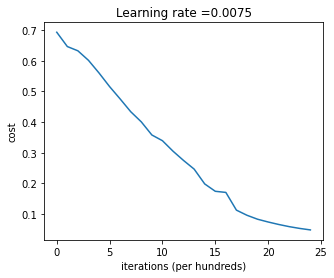

In [ ]:
model_1 = train_model(
    train_set_x, train_set_y, 
    layer_dims = (n_x, n_h, n_y), 
    activations = ("relu", "sigmoid"),
    num_iterations = 2500, #2500, 
    print_cost=True)

**Expected Output**:
<table> 
    <tr>
        <td> **Cost after iteration 0**</td>
        <td> 0.6930497356599888 </td>
    </tr>
    <tr>
        <td> **Cost after iteration 100**</td>
        <td> 0.6464320953428849 </td>
    </tr>
    <tr>
        <td> **...**</td>
        <td> ... </td>
    </tr>
    <tr>
        <td> **Cost after iteration 2400**</td>
        <td> 0.048554785628770226 </td>
    </tr>
</table>

### 11 - Vorhersagen Treffen ###

Mit Hilfe der gelernet Parameter können nun die Klassen für neune Eingaben $X$ vorhergesagt werden.

Implementieren Sie eine Funktion (`model_forward(X, Y, parameters)`), das die Eingabe $X$ übernimmt und die entsprechenden Ausgaben (Vorhersagen) berechnet und zurückliefert.

In [ ]:
def model_forward(X, parameters, activations):
    """
    Implement forward propagation for the two layer neural network
    
    Arguments:
    X -- data, numpy array of shape (input size, number of examples)
    parameters -- output of initialize_parameters_deep()
    
    Returns:
    AL -- last post-activation value
    caches -- list of caches containing every cache of forward_step()
    """

    caches = []
    L = 2                  # number of layers in the neural network
    g1, g2 = activations
    ### START HERE: Replace the "None" instances with your code ###

    # Implement [LINEAR -> RELU]*(L-1). Add "cache" to the "caches" list.
    A, cache = forward_step(X,parameters['W1'],parameters['b1'],g1)
    caches.append(cache)
    
    AL, cache = forward_step(A,parameters['W2'],parameters['b2'],g2)
    caches.append(cache)
    
    ### END HERE ###
    
    assert(AL.shape == (1,X.shape[1]))
            
    return AL, caches

In [ ]:
# Calculate predictions for the test data
probabilities, cache = model_forward(test_set_x, model_1, activations)
print(probabilities[0,1:5])

[0.96543173 0.93197208 0.95346393 0.91520565]


### 12 - Performanzanalyse ##

Implementieren Sie eine Funktion `test_predict(X, Y, parameters)`, das für die Eingabe $X$ die entsprechenden Vorhersagen und die Genauigkeit des Modells zurückliefert.

In [ ]:
def test_predict(X, Y, parameters, activations):
    """
    This function is used to predict the results of a  2-layer neural network.
    
    Arguments:
    X -- data set of examples you would like to label
    Y -- true labels for the examples X
    parameters -- parameters of the trained model
    
    Returns:
    p -- predictions for the given dataset X
    """
    
    m = X.shape[1]
    n = len(parameters) // 2 # number of layers in the neural network
    p = np.zeros((1,m))
    
    ### START HERE: Replace the "None" instances with your code ###
    # Forward propagation
    probabilities, caches = model_forward(X,parameters,activations)
    ### END HERE ###
    
    # convert probas to 0/1 predictions
    for i in range(0, probabilities.shape[1]):
        if probabilities[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0
    
    accuracy = np.sum((p == Y)/m)
        
    return (p, accuracy)

In [ ]:
# Train set accuray of our model_1
predictions, accuracy = test_predict(train_set_x, train_set_y, model_1, activations)
print("Accuracy: ", accuracy)

Accuracy:  0.9999999999999998


In [ ]:
# Test set accuray of our model_1
predictions_test, accuracy_test = test_predict(test_set_x, test_set_y, model_1, activations)
print("Accuracy: ", accuracy_test)
print("Predictions: ", predictions_test)
print("True Labels: ", test_set_y)

Accuracy:  0.72
Predictions:  [[1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1.
  1. 1. 1. 0. 0. 1. 0. 1. 1. 1. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 1. 0. 1.
  1. 0.]]
True Labels:  [[1 1 1 1 1 0 1 1 1 1 1 1 1 0 0 1 0 1 1 1 1 0 0 1 1 1 1 0 1 0 1 1 1 1 0 0
  0 1 0 0 1 1 1 0 0 0 1 1 1 0]]


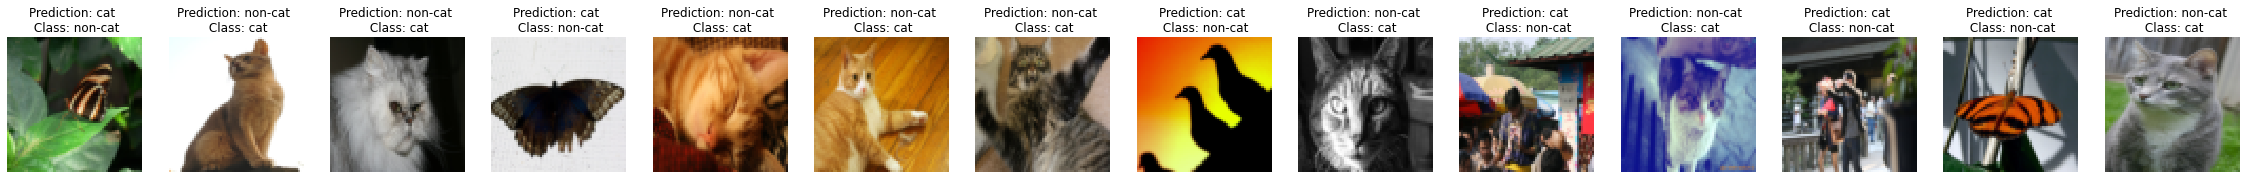

In [ ]:
#Plot some images where predictions and truth were different.
p = predictions_test
a = predictions_test + test_set_y
mislabeled_indices = np.asarray(np.where(a == 1))
X = test_set_x
y = test_set_y

plt.rcParams['figure.figsize'] = (40.0, 40.0)     # set default size of plots
num_images = len(mislabeled_indices[0])
for i in range(num_images):
    index = mislabeled_indices[1][i]
    plt.subplot(2, num_images, i + 1)
    plt.imshow(X[:,index].reshape(64,64,3), interpolation='nearest')
    plt.axis('off')
    plt.title("Prediction: " + classes[int(p[0,index])].decode("utf-8") + " \n Class: " + classes[y[0,index]].decode("utf-8"))